# EURO STOXX50 - Base GBM Model

In this notebook, we detail our implementation of our base Geometric Brownian Motion model for the [Outperformance Bonus Certificate EURO STOXX 50](https://derivative.credit-suisse.com/ch/ch/en/detail/outperformance-bonus-certificate-euro-stoxx-50/CH1149494077/114949407), a derivative of the SX5E stock.

In [1]:
# External Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from numba import jit
import time

# Our Code
from payoff_function import PayoffFunctions

We import our historical stock data into a Pandas dataframe called `S_all`:

In [2]:
S_all = pd.read_csv("STOXX50E_1Aug2022_3Nov2023.csv")
S_all = S_all[['Date', 'Adj Close']]

We then import the Euro area yields with 1-year maturity period as data for our risk-free interest rate:

In [3]:
ir = pd.read_csv("euro_area_1_year_yield_curve.csv").rename(columns={"DATE": "Date", "TIME PERIOD": "Date String", "Yield curve spot rate, 1-year maturity - Government bond, nominal, all issuers whose rating is triple A - Euro area (changing composition) (YC.B.U2.EUR.4F.G_N_A.SV_C_YM.SR_1Y)": "Interest Rate"})
ir

,Date,Date String,Interest Rate
0,2004-09-06,06 Sep 2004,2.298838
1,2004-09-07,07 Sep 2004,2.328891
2,2004-09-08,08 Sep 2004,2.346666
3,2004-09-09,09 Sep 2004,2.308988
4,2004-09-10,10 Sep 2004,2.271566
...,...,...,...
4897,2023-10-27,27 Oct 2023,3.420809
4898,2023-10-30,30 Oct 2023,3.406159
4899,2023-10-31,31 Oct 2023,3.387519
4900,2023-11-01,01 Nov 2023,3.376730


Our timestep (dt) is defined as $\frac{1}{252}$, indicating 1 day out of 252 working days in a year.

In [4]:
dt = 1/252

We start from 9 August 2023, and look back 252 timesteps for our historical data. This gives us a total of 252 trading days from 11 August 2022 to 9 August 2023.

In [5]:
date_index = S_all.loc[S_all['Date'] == '2023-08-09'].index[0] + 1
S_all.iloc[date_index-252:date_index, ]

,Date,Adj Close
7,2022-08-11,3757.050049
8,2022-08-12,3776.810059
9,2022-08-15,3789.620117
10,2022-08-16,3805.219971
11,2022-08-17,3756.060059
...,...,...
254,2023-08-03,4304.629883
255,2023-08-04,4332.910156
256,2023-08-07,4337.500000
257,2023-08-08,4288.850098


We then obtain the adjusted close price of this historical data, and compute the log-returns:

In [6]:
history_data = list(S_all.iloc[date_index-252:date_index, ]['Adj Close'])
log_history_data = np.log(history_data)
log_return = log_history_data[1:] - log_history_data[:-1]

We next compute our model parameters, $\sigma$ (sample variance) and $v = r - \frac{\sigma^2}{2}$, which we will use in our simulation functions below. Our $r$ used is the Euro area yield curve yields for 1-year maturity for 8 August 2023, taken from the [European Central Bank data portal](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html).

We choose 8 August 2023 for $r$, as we are trying to emulate the actual data available to us before the trading day closes on 9 August 2023.

In [7]:
sigma = np.std(log_return)/np.sqrt(dt)

r = ir[ir['Date'] == '2023-08-08']['Interest Rate'].iloc[0] / 100
v = r - sigma**2 / 2

print(f"v: {v}")
print(f"Sigma: {sigma}")

v: 0.018269417834539912
Sigma: 0.17080938010226537


### Exact GBM Simulation

In [8]:
def simulate_gbm_exact(n_sim, S_0, v, sigma, delta_t, T):
    '''
    GBM simulation using Monte Carlo

    Takes in the following parameters:
    - n_sim (integer): No. of simulations to generate
    - S_0 (float): Price of S at time 0
    - v (float): Given by (r - sigma^2 / 2), where r is the risk-free interest rate 
                 and sigma is the volatility calculated from historical data
    - sigma (float): Volatility calculated from historical data (sqrt of variance)
    - delta_t (float): Value of one timestep (e.g. 1 / 252, 1 day out of 252 working days in a year)
    - T (float): End date, used to calculate no. of periods
    '''
    n_periods = int(T / delta_t)
    S_t = np.full((n_sim, n_periods+1), S_0)
    Z = np.random.normal(size=(n_sim, n_periods))

    for i in tqdm(range(n_sim)):
    # for i in range(n_sim):
        for j in range(1, n_periods+1):
            S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t + sigma*np.sqrt(delta_t)*Z[i][j-1])
            # S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t - 0.5*(sigma**2)*delta_t + sigma*np.sqrt(delta_t)*Z[i][j-1])
    return S_t

@jit
def simulate_gbm_exact_jit(n_sim, S_0, v, sigma, delta_t, T):
    '''
    GBM simulation using Monte Carlo

    Takes in the following parameters:
    - n_sim (integer): No. of simulations to generate
    - S_0 (float): Price of S at time 0
    - v (float): Given by (r - sigma^2 / 2), where r is the risk-free interest rate 
                 and sigma is the volatility calculated from historical data
    - sigma (float): Volatility calculated from historical data (sqrt of variance)
    - delta_t (float): Value of one timestep (e.g. 1 / 252, 1 day out of 252 working days in a year)
    - T (float): End date, used to calculate no. of periods
    '''
    n_periods = int(T / delta_t)
    S_t = np.full((n_sim, n_periods+1), S_0)
    Z = np.random.normal(size=(n_sim, n_periods))

    # for i in tqdm(range(n_sim)):
    for i in range(n_sim):
        for j in range(1, n_periods+1):
            S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t + sigma*np.sqrt(delta_t)*Z[i][j-1])
            # S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t - 0.5*(sigma**2)*delta_t + sigma*np.sqrt(delta_t)*Z[i][j-1])
    return S_t

/tmp/ipykernel_64433/2582766409.py:25: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


In [9]:
sim_S = simulate_gbm_exact_jit(10, history_data[-1], v, sigma, dt, 1)
print(f"No. of timesteps simulated: {len(sim_S[0])}")

/tmp/ipykernel_64433/2582766409.py:25: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "simulate_gbm_exact_jit" failed type inference due to: No implementation of function Function(<built-in method normal of numpy.random.mtrand.RandomState object at 0x7f7db3f37640>) found for signature:
 
 >>> normal(size=UniTuple(int64 x 2))
 
There are 8 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'np_gauss_impl0': File: numba/cpython/randomimpl.py: Line 285.
    With argument(s): '(size=UniTuple(int64 x 2))':
   Rejected as the implementation raised a specific error:
     TypingError: got an unexpected keyword argument 'size'
  raised from /home/nicholas/Environments/pytorch/lib/python3.11/site-packages/numba/core/typing/templates.py:784
  - Of which 6 did not match due to:
  Overload in function 'np_gauss_impl1': File: numba/cpython/randomimpl.py: Line 291.
    With argument(s): '(size=UniTuple(int64 x 2)

No. of timesteps simulated: 253


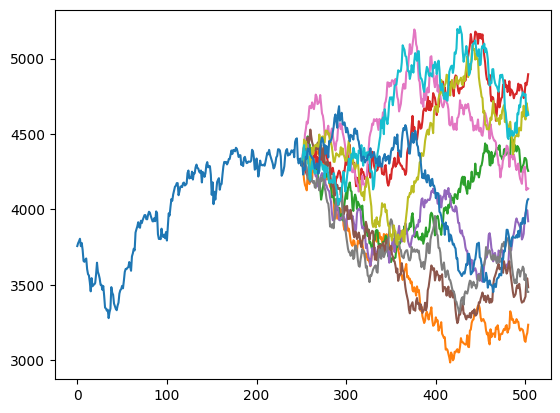

In [10]:
plot1 = pd.Series(history_data, index=np.arange(len(history_data)))
plt.plot(plot1)
for i in range(len(sim_S)):
    plot2 = pd.Series(sim_S[i], index=np.arange(len(history_data)-1, len(history_data)-1+len(sim_S[0])))
    plt.plot(plot2)
plt.show()

# Risk-Neutral Valuation

In [11]:
r = ir[ir['Date'] == '2023-08-08']['Interest Rate'].values[0] / 100
v = r - sigma**2 / 2
St = history_data[-1]
Nsim=100000
T = 485/252
print(f"r: {r}")
print(f"v: {v}")

r: 0.03285734
v: 0.018269417834539912


### Normal Monte Carlo Simulation

In [12]:
predicted_derivative_dict = dict()

In [13]:
# TODO: Populate list with dates in sliding window
predicted_derivative_dict['date'] = ['2023-08-09']

In [14]:
mc_jit_start = time.perf_counter()
sim_S_jit = simulate_gbm_exact_jit(Nsim, St, v, sigma, dt, T)
mc_jit_end = time.perf_counter()
print(f"Time taken: {mc_jit_end - mc_jit_start}s")

# mc_start = time.perf_counter()
# sim_S = simulate_gbm_exact(Nsim, St, v, sigma, dt, T)
# mc_end = time.perf_counter()
# print(f"Time taken: {mc_end - mc_start}s")

/tmp/ipykernel_64433/2582766409.py:25: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "simulate_gbm_exact_jit" failed type inference due to: No implementation of function Function(<built-in method normal of numpy.random.mtrand.RandomState object at 0x7f7db3f37640>) found for signature:
 
 >>> normal(size=UniTuple(int64 x 2))
 
There are 8 candidate implementations:
    - Of which 2 did not match due to:
    Overload in function 'np_gauss_impl0': File: numba/cpython/randomimpl.py: Line 285.
      With argument(s): '(size=UniTuple(int64 x 2))':
     Rejected as the implementation raised a specific error:
       TypingError: got an unexpected keyword argument 'size'
  raised from /home/nicholas/Environments/pytorch/lib/python3.11/site-packages/numba/core/typing/templates.py:784
    - Of which 6 did not match due to:
    Overload in function 'np_gauss_impl1': File: numba/cpython/randomimpl.py: Line 291.
      With argument(s): '(size=Uni

Time taken: 1.6719482140015316s


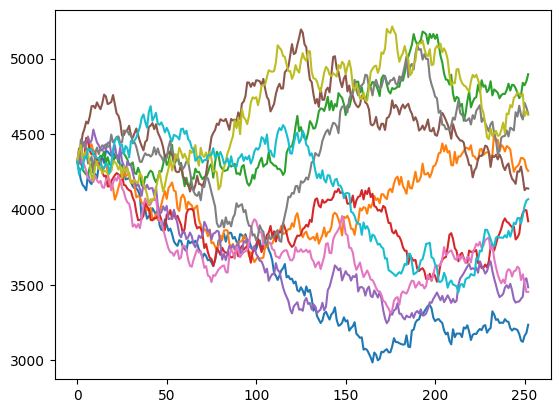

In [15]:
for i in range(len(sim_S[:50])):
    plot3 = pd.Series(sim_S[i])
    plt.plot(plot3)
plt.show()

In [16]:
sim_S_df = pd.DataFrame(sim_S_jit)

In [17]:
sim_Note = np.exp(-r*T)*sim_S_df.apply(PayoffFunctions.payoff_original, axis=1)
note_MC = np.mean(sim_Note)
note_MC_var = np.var(sim_Note)/Nsim
lower_percentile = note_MC-1.96*np.sqrt(note_MC_var)
higher_percentile = note_MC+1.96*np.sqrt(note_MC_var)

In [18]:
# TODO: Populate list with MC mean and var in sliding window
predicted_derivative_dict['MC_Mean'] = [note_MC]
predicted_derivative_dict['MC_Var'] = [note_MC_var]

In [19]:
print(f"Note Value (MC): {note_MC}")
print(f"Estimate Variance: {note_MC_var}")
print(f"95% Confidence Interval: [{lower_percentile}, {higher_percentile}]")

Note Value (MC): 1413.1842261328438
Estimate Variance: 1.7327723795048273
95% Confidence Interval: [1410.6041838128217, 1415.764268452866]


### Antithetic Variate Simulation

In [20]:
def simulate_gbm_exact_av(n_sim, S_0, v, sigma, delta_t, T, collate=False):
    '''
    GBM simulation using Monte Carlo with antithetic variates

    Takes in the following parameters:
    - n_sim (integer): No. of simulations to generate
    - S_0 (float): Price of S at time 0
    - v (float): Given by (r - sigma^2 / 2), where r is the risk-free interest rate 
                 and sigma is the volatility calculated from historical data
    - sigma (float): Volatility calculated from historical data (sqrt of variance)
    - delta_t (float): Value of one timestep (e.g. 1 / 252, 1 day out of 252 working days in a year)
    - T (float): End date, used to calculate no. of periods
    - collate - Boolean: True - Returns [S_t[0], S_tilde_t[0], ..., S_t[n_sim-1], S_tilde_t[n_sim-1]],
                         False - Returns [S_t[0], ..., S_t[n_sim-1], S_tilde_t[0], ..., S_tilde_t[n_sim-1]],
    '''
    n_periods = int(T / delta_t)
    S_t = np.full((n_sim, n_periods+1), S_0)
    S_tilde_t = np.full((n_sim, n_periods+1), S_0)
    Z = np.random.normal(size=(n_sim, n_periods))
    
    for i in tqdm(range(n_sim)):
    # for i in range(n_sim):
        for j in range(1, n_periods+1):
            S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t + sigma * np.sqrt(delta_t) * Z[i][j-1])
            S_tilde_t[i][j] = S_tilde_t[i][j-1] * np.exp(v*delta_t + sigma * np.sqrt(delta_t) * (-Z[i][j-1]))
            # S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t - 0.5*(sigma**2)*delta_t + sigma * np.sqrt(delta_t) * Z[i][j-1])
            # S_tilde_t[i][j] = S_tilde_t[i][j-1] * np.exp(v*delta_t - 0.5*(sigma**2)*delta_t + sigma * np.sqrt(delta_t) * (-Z[i][j-1]))

    if collate:
        collated = [None] * (2*n_sim)
        for i in range(n_sim):
            collated[2*i] = S_t[i]
            collated[2*i+1] = S_tilde_t[i]
        return collated
    S_t = np.append(S_t, S_tilde_t, 0)
    return S_t

@jit
def simulate_gbm_exact_av_jit(n_sim, S_0, v, sigma, delta_t, T):
    '''
    GBM simulation using Monte Carlo with antithetic variates

    Takes in the following parameters:
    - n_sim (integer): No. of simulations to generate
    - S_0 (float): Price of S at time 0
    - v (float): Given by (r - sigma^2 / 2), where r is the risk-free interest rate 
                 and sigma is the volatility calculated from historical data
    - sigma (float): Volatility calculated from historical data (sqrt of variance)
    - delta_t (float): Value of one timestep (e.g. 1 / 252, 1 day out of 252 working days in a year)
    - T (float): End date, used to calculate no. of periods
    - collate - Boolean: True - Returns [S_t[0], S_tilde_t[0], ..., S_t[n_sim-1], S_tilde_t[n_sim-1]],
                         False - Returns [S_t[0], ..., S_t[n_sim-1], S_tilde_t[0], ..., S_tilde_t[n_sim-1]],
    '''
    n_periods = int(T / delta_t)
    S_t = np.full((n_sim*2, n_periods+1), S_0) # Combined S_tilde_t with S_t
    Z = np.random.normal(size=(n_sim, n_periods))
    
    #for i in tqdm(range(n_sim)):
    for i in range(n_sim):
        for j in range(1, n_periods+1):
            S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t + sigma * np.sqrt(delta_t) * Z[i][j-1])
            # S_tilde is stored in the second half of the array
            S_t[n_sim+i][j] = S_t[n_sim+i][j-1] * np.exp(v*delta_t + sigma * np.sqrt(delta_t) * (-Z[i][j-1]))

    return S_t

/tmp/ipykernel_64433/1724112361.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


In [21]:
av_jit_start = time.perf_counter()
sim_S_AV_jit = simulate_gbm_exact_av_jit(int(Nsim/2), St, v, sigma, dt, T)
av_jit_end = time.perf_counter()
print(f"Time taken: {av_jit_end - av_jit_start}s")
sim_S_AV_df = pd.DataFrame(sim_S_AV_jit)

# av_start = time.perf_counter()
# sim_S_AV = simulate_gbm_exact_av(int(Nsim/2), St, v, sigma, dt, T)
# sim_S_AV_df = pd.DataFrame(sim_S_AV)
# av_end = time.perf_counter()
# print(f"Time taken: {av_end - av_start}s")

/tmp/ipykernel_64433/1724112361.py:38: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "simulate_gbm_exact_av_jit" failed type inference due to: No implementation of function Function(<built-in method normal of numpy.random.mtrand.RandomState object at 0x7f7db3f37640>) found for signature:
 
 >>> normal(size=UniTuple(int64 x 2))
 
There are 8 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function 'np_gauss_impl0': File: numba/cpython/randomimpl.py: Line 285.
        With argument(s): '(size=UniTuple(int64 x 2))':
       Rejected as the implementation raised a specific error:
         TypingError: got an unexpected keyword argument 'size'
  raised from /home/nicholas/Environments/pytorch/lib/python3.11/site-packages/numba/core/typing/templates.py:784
      - Of which 6 did not match due to:
      Overload in function 'np_gauss_impl1': File: numba/cpython/randomimpl.py: Line 291.
        With argu

Time taken: 1.4179784680000012s


In [22]:
sim_Note_AV = np.exp(-r*T)*sim_S_AV_df.apply(PayoffFunctions.payoff_original, axis=1)
note_AV = np.mean(sim_Note_AV)
note_AV_var = np.var(sim_Note_AV)/Nsim
lower_percentile = note_AV-1.96*np.sqrt(note_AV_var)
higher_percentile = note_AV+1.96*np.sqrt(note_AV_var)

In [23]:
# TODO: Populate list with AV Mean and Var in sliding window
predicted_derivative_dict['AV_Mean'] = [note_AV]
predicted_derivative_dict['AV_Var'] = [note_AV_var]

In [24]:
print(f"Note Value (AV): {note_AV}")
print(f"Estimate Variance: {note_AV_var}")
print(f"95% Confidence Interval: [{lower_percentile}, {higher_percentile}]")

Note Value (AV): 1410.0051660535876
Estimate Variance: 1.7088765683714315
95% Confidence Interval: [1407.4429755405586, 1412.5673565666166]


### Control Variate Simulation

In [25]:
def simulate_gbm_exact_cv(n_sim, S_0, v, sigma, delta_t, T, payoff_fn, n1=1000):
    hsi_simulations_pre = simulate_gbm_exact(n1, S_0, v, sigma, delta_t, T)
    payoffs_pre = np.array([payoff_fn(sim) for sim in hsi_simulations_pre])
    sim_notes_pre = np.exp(-r * T) * payoffs_pre
    c = -np.cov(sim_notes_pre, hsi_simulations_pre[:,-1])[0,1] / (S_0**2 * np.exp(2*r*T) * (np.exp(sigma**2*T)-1))
    
    hsi_simulations_cv = simulate_gbm_exact(n_sim, S_0, v, sigma, delta_t, T)
    payoffs_cv = np.array([payoff_fn(sim) for sim in hsi_simulations_cv])
    sim_notes_cv = np.exp(-r * T) * payoffs_cv + c*(hsi_simulations_cv[:,-1] - S_0*np.exp(r*T))
    return sim_notes_cv

@jit
def simulate_gbm_exact_cv_jit(n_sim, S_0, v, sigma, delta_t, T, payoff_fn, n1=1000):
    hsi_simulations_pre = simulate_gbm_exact_jit(n1, S_0, v, sigma, delta_t, T)
    payoffs_pre = np.array([payoff_fn(sim) for sim in hsi_simulations_pre])
    sim_notes_pre = np.exp(-r * T) * payoffs_pre
    c = -np.cov(sim_notes_pre, hsi_simulations_pre[:,-1])[0,1] / (S_0**2 * np.exp(2*r*T) * (np.exp(sigma**2*T)-1))
    
    hsi_simulations_cv = simulate_gbm_exact_jit(n_sim, S_0, v, sigma, delta_t, T)
    payoffs_cv = np.array([payoff_fn(sim) for sim in hsi_simulations_cv])
    sim_notes_cv = np.exp(-r * T) * payoffs_cv + c*(hsi_simulations_cv[:,-1] - S_0*np.exp(r*T))
    return sim_notes_cv

/tmp/ipykernel_64433/1578277947.py:12: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


In [26]:
# sim_Note_CV = simulate_gbm_exact_cv(Nsim, St, v, sigma, dt, T, payoff_fn=PayoffFunctions.payoff_original)
cv_jit_start = time.perf_counter()
sim_Note_CV_jit = simulate_gbm_exact_cv_jit(Nsim, St, v, sigma, dt, T, payoff_fn=PayoffFunctions.payoff_original)
cv_jit_end = time.perf_counter()
print(f"Time taken: {cv_jit_end - cv_jit_start}s")

/tmp/ipykernel_64433/1578277947.py:12: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "simulate_gbm_exact_cv_jit" failed type inference due to: non-precise type pyobject
During: typing of argument at /tmp/ipykernel_64433/1578277947.py (12)

File "../../../../../tmp/ipykernel_64433/1578277947.py", line 12:
<source missing, REPL/exec in use?>

  @jit
/home/nicholas/Environments/pytorch/lib/python3.11/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "simulate_gbm_exact_cv_jit" was compiled in object mode without forceobj=True.

File "../../../../../tmp/ipykernel_64433/1578277947.py", line 12:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/nicholas/Environments/pytorch/lib/python3.11/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected. This is depr

Time taken: 4.238475242000277s


In [27]:
note_CV = np.mean(sim_Note_CV_jit)
note_CV_var = np.var(sim_Note_CV_jit)/Nsim
lower_percentile = note_CV-1.96*np.sqrt(note_CV_var)
higher_percentile = note_CV+1.96*np.sqrt(note_CV_var)

In [28]:
# TODO: Populate list with CV Mean and Var in sliding window
predicted_derivative_dict['CV_Mean'] = [note_CV]
predicted_derivative_dict['CV_Var'] = [note_CV_var]

In [29]:
print(f"Note Value (CV): {note_CV}")
print(f"Estimate Variance: {note_CV_var}")
print(f"95% Confidence Interval: [{lower_percentile}, {higher_percentile}]")

Note Value (CV): 1410.6012270389554
Estimate Variance: 0.04618982487242634
95% Confidence Interval: [1410.1799874026083, 1411.0224666753024]


### Stratified Sampling Simulation

In [58]:
def simulate_gbm_1_shoot_ss(n_strata, n_sim_s, S_0, v, sigma, T):
    '''
    GBM simulation using Monte Carlo with stratified sampling

    Takes in the following parameters:
    - n_strata (integer): No. of strata
    - n_sim_s (integer): No. of simulations to generate per strata (Total = n_strata * n_sim_s)
    - S_0 (float): Price of S at time 0
    - v (float): Given by (r - sigma^2 / 2), where r is the risk-free interest rate 
                 and sigma is the volatility calculated from historical data
    - sigma (float): Volatility calculated from historical data (sqrt of variance)
    - T (float): End date, used to calculate no. of periods
    '''
    V = np.random.uniform(size=n_sim_s) / n_strata
    for i in range(1, n_strata):
        V = np.append(V, (i + np.random.uniform(size=n_sim_s)) / n_strata, 0 )
    Z = np.array(scipy.stats.norm.ppf(V))
    S_T = S_0 * np.exp(v*T + sigma*np.sqrt(T)*Z)
    # S_T = S_0 * np.exp(v*T - 0.5*(sigma**2)*T + sigma*np.sqrt(T)*Z)
    return S_T.reshape(n_sim_s*n_strata, 1)

@jit
def simulate_gbm_1_shoot_ss_jit(n_strata, n_sim_s, S_0, v, sigma, T):
    '''
    GBM simulation using Monte Carlo with stratified sampling

    Takes in the following parameters:
    - n_strata (integer): No. of strata
    - n_sim_s (integer): No. of simulations to generate per strata (Total = n_strata * n_sim_s)
    - S_0 (float): Price of S at time 0
    - v (float): Given by (r - sigma^2 / 2), where r is the risk-free interest rate 
                 and sigma is the volatility calculated from historical data
    - sigma (float): Volatility calculated from historical data (sqrt of variance)
    - T (float): End date, used to calculate no. of periods
    '''
    V = np.empty(n_strata*n_sim_s, dtype=np.float64)
    for i in range(n_strata):
        V[i*n_sim_s:(i+1)*n_sim_s] = (i + np.random.uniform(size=n_sim_s)) / n_strata
        # V = np.append(V, (i + np.random.uniform(size=n_sim_s)) / n_strata, 0 )
    Z = np.array(scipy.stats.norm.ppf(V))
    S_T = S_0 * np.exp(v*T + sigma*np.sqrt(T)*Z)
    # S_T = S_0 * np.exp(v*T - 0.5*(sigma**2)*T + sigma*np.sqrt(T)*Z)
    return S_T.reshape(n_sim_s*n_strata, 1)

/tmp/ipykernel_64433/4110670031.py:22: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


In [59]:
n_strata = 5
n_sim_s = Nsim // n_strata
# sim_S_SS = simulate_gbm_1_shoot_ss(n_strata, n_sim_s, St, v, sigma, T)
ss_jit_start = time.perf_counter()
sim_S_SS_jit = simulate_gbm_1_shoot_ss_jit(n_strata, n_sim_s, St, v, sigma, T)
ss_jit_end = time.perf_counter()
print(f"Time taken: {ss_jit_end - ss_jit_start}s")
sim_S_SS_df = pd.DataFrame(sim_S_SS_jit)

/tmp/ipykernel_64433/4110670031.py:22: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "simulate_gbm_1_shoot_ss_jit" failed type inference due to: No implementation of function Function(<built-in method uniform of numpy.random.mtrand.RandomState object at 0x7f7db3f37640>) found for signature:
 
 >>> uniform(size=int64)
 
There are 8 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function 'np_uniform_impl0': File: numba/cpython/randomimpl.py: Line 622.
        With argument(s): '(size=int64)':
       Rejected as the implementation raised a specific error:
         TypingError: got an unexpected keyword argument 'size'
  raised from /home/nicholas/Environments/pytorch/lib/python3.11/site-packages/numba/core/typing/templates.py:784
      - Of which 6 did not match due to:
      Overload in function 'np_uniform_impl1': File: numba/cpython/randomimpl.py: Line 633.
        With argument(s): '(size=int6

Time taken: 0.6198314369994478s


In [60]:
sim_Note_SS = np.exp(-r*T)*sim_S_SS_df.apply(PayoffFunctions.payoff_original, axis=1)
note_SS = np.mean(sim_Note_SS)
note_SS_var = np.var(sim_Note_SS)/Nsim
lower_percentile = note_SS-1.96*np.sqrt(note_SS_var)
higher_percentile = note_SS+1.96*np.sqrt(note_SS_var)

In [61]:
# TODO: Populate list with SS Mean and Var in sliding window
predicted_derivative_dict['SS_Mean'] = [note_SS]
predicted_derivative_dict['SS_Var'] = [note_SS_var]

In [62]:
print(f"Note Value (SS): {note_SS}")
print(f"Estimate Variance: {note_SS_var}")
print(f"95% Confidence Interval: [{lower_percentile}, {higher_percentile}]")

Note Value (SS): 1410.5397644740644
Estimate Variance: 1.715343444369412
95% Confidence Interval: [1407.972730509371, 1413.1067984387578]


### Empirical Martingale Simulation

In [63]:
@jit
def simulate_gbm_ems(sim_paths, delta_t, r):
    '''
    GBM simulation using Empirical Martingale Simulation

    Takes in the following parameters:
    - sim_paths (np.array): List of paths generated from `simulate_gbm_exact`, shape: (n_sim, n_periods+1)
    - delta_t (float): Value of one timestep (e.g. 1/252, 1 day out of 252 working days in a year)
    - r (float): Risk-free interest rate
    '''
    n_sim = sim_paths.shape[0]
    n_periods = sim_paths.shape[1] - 1
    S = np.zeros((n_sim, n_periods+1))
    Z = np.zeros((n_sim+1, n_periods))
    S[:, 0] = sim_paths[:, 0]

    for j in range(1, n_periods+1):
        Z[:n_sim, j-1] = S[:,j-1]*sim_paths[:, j] / sim_paths[:, j-1]
        Z[n_sim,j-1] = np.exp(-r*((j-1)*delta_t)) * np.mean(Z[:n_sim,j-1])
        S[:,j] = sim_paths[:, 0] * Z[:n_sim, j-1] / Z[n_sim, j-1]
    return S

/tmp/ipykernel_64433/2346715112.py:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


In [65]:
ems_jit_start = time.perf_counter()
sim_S_EMS = simulate_gbm_ems(sim_S, dt, r)
ems_jit_end = time.perf_counter()
print(f"Time taken: {ems_jit_end - ems_jit_start}s")
sim_S_EMS_df = pd.DataFrame(sim_S_EMS)

Time taken: 0.00023576999956276268s


In [66]:
sim_Note_EMS = np.exp(-r*T)*sim_S_EMS_df.apply(PayoffFunctions.payoff_original, axis=1)
note_EMS = np.mean(sim_Note_EMS)
note_EMS_var = np.var(sim_Note_EMS)/Nsim
lower_percentile = note_EMS-1.96*np.sqrt(note_EMS_var)
higher_percentile = note_EMS+1.96*np.sqrt(note_EMS_var)

In [67]:
# TODO: Populate list with EMS Mean and Var in sliding window
predicted_derivative_dict['EMS_Mean'] = [note_EMS]
predicted_derivative_dict['EMS_Var'] = [note_EMS_var]

In [68]:
predicted_derivative_df = pd.DataFrame(predicted_derivative_dict, columns=['date', 'MC_Mean', 'MC_Var', 'AV_Mean', 'AV_Var', 'CV_Mean', 'CV_Var', 'SS_Mean', 'SS_Var', 'EMS_Mean', 'EMS_Var'])

In [69]:
print(f"Note Value (EMS): {note_EMS}")
print(f"Estimate Variance: {note_EMS_var}")
print(f"95% Confidence Interval: [{lower_percentile}, {higher_percentile}]")

Note Value (EMS): 1331.988601702941
Estimate Variance: 0.5471312579962893
95% Confidence Interval: [1330.5388226022783, 1333.4383808036036]


## Comparison - Predicted vs Actual Derivative price

We import the actual derivative price data, scraped from the Credit Suisse page for comparison against our predicted derivative price:

In [70]:
actual_derivative_df = pd.read_csv('Outperformance_Bonus_Certificate_EURO_STOXX_50.csv')
actual_derivative_df

,date,value
0,2022-07-15,1004.94
1,2022-07-18,1014.34
2,2022-07-19,1038.38
3,2022-07-20,1035.84
4,2022-07-21,1038.86
...,...,...
330,2023-11-06,1225.93
331,2023-11-07,1224.44
332,2023-11-08,1232.53
333,2023-11-09,1251.19


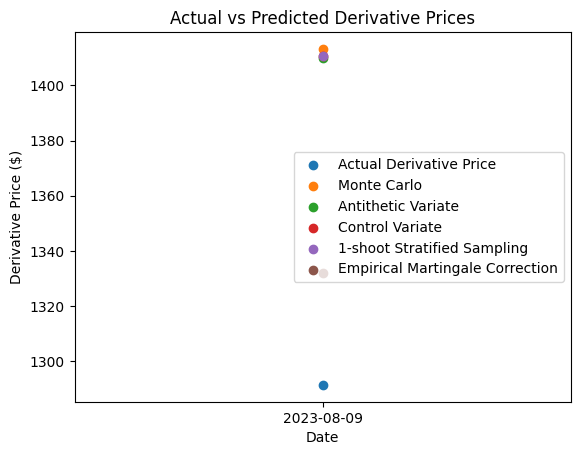

In [71]:
# TODO: Update date ranges for sliding window
actual_derivative_range_df = actual_derivative_df[actual_derivative_df['date'] == '2023-08-09']
predicted_derivative_range_df = predicted_derivative_df[predicted_derivative_df['date'] == '2023-08-09']

# TODO: Change to plt.plot for sliding window
plt.scatter(actual_derivative_range_df['date'], actual_derivative_range_df['value'], label='Actual Derivative Price')
plt.scatter(predicted_derivative_df['date'], predicted_derivative_range_df['MC_Mean'], label='Monte Carlo')
plt.scatter(predicted_derivative_df['date'], predicted_derivative_range_df['AV_Mean'], label='Antithetic Variate')
plt.scatter(predicted_derivative_df['date'], predicted_derivative_range_df['CV_Mean'], label='Control Variate')
plt.scatter(predicted_derivative_df['date'], predicted_derivative_range_df['SS_Mean'], label='1-shoot Stratified Sampling')
plt.scatter(predicted_derivative_df['date'], predicted_derivative_range_df['EMS_Mean'], label='Empirical Martingale Correction')
plt.legend()
plt.title("Actual vs Predicted Derivative Prices")
plt.xlabel("Date")
plt.ylabel("Derivative Price ($)")
plt.show()

In [72]:
# TODO: Calculate difference for each method used


The above plot shows that our GBM model overestimates the actual derivative price by more than EUR100, which indicates that our model differs greatly from the model that Credit Suisse uses to price their own option.